# Lyrics Classification Weekly Project

## Import Libraries

In [10]:
import string
import re
import random
import requests
import time
import os

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import contractions

from bs4 import BeautifulSoup

import pattern
from pattern.en import lemma, lexeme

from textblob import TextBlob, Word

import nltk 
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TreebankWordTokenizer
from nltk.tokenize import word_tokenize
from nltk.stem import wordnet
from nltk import pos_tag


from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score

## Headers for requests (To avoid getting blocked)

In [11]:
header1 = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}
header2 = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/16.0 Safari/605.1.15'}
header3 = {'User_Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/106.0.0.0 Safari/537.36'}

In [12]:
HEADERS = [header1, header2, header3]

## Function to scrape links of songs for an Artist

In [13]:
def lyrics_scrapper(artist):
    """
    Web scrapper for extracting links of song lyrics from songtexte.de for the artist.
    
    Argument
    -----------------
    artist : str
    
    The name of an artist or band
    
    Returns
    ------------------
    song_list : list
    
    """
    artist = artist.lower()
    names = artist.split()
    search = ""
    for name in names:
        if search == "":
            search = name
        else:
            search = search + "+"  + name
    param = {'q': search, 'c': 'all'}
    search_request = requests.get('https://www.songtexte.com/search', params=param)
    search_request = search_request.text
    search_soup = BeautifulSoup(search_request, 'html.parser')
    search_soup_link = search_soup.find('a', class_='topHitLink').get('href')
    main_link = 'https://www.songtexte.com/'
    search_link = main_link + search_soup_link
    
    song_request = requests.get(search_link)
    song_request = song_request.text
    song_soup = BeautifulSoup(song_request, 'html.parser')
    lyricsoup = song_soup.find('div', class_='albumList', id=True).find_all('a', class_='nested')
    
    song_list = []
    for lyric in lyricsoup:
        temp_link = lyric.get('href')
        song_list.append(temp_link[2:])
      
        
    return song_list, artist

## Function to save the songs from a list of links

In [14]:
def save_songs(list, artist):
    link = 'https://www.songtexte.com'
    artist_lower = artist.lower()
    foldername = "".join(artist_lower.split())
    if not os.path.exists(f'./{foldername}'):
        os.mkdir(f'./{foldername}/')
    for song in list:
        filename = song[-13:]
        song_link = song
        request = requests.get(link + song_link, headers = random.choice(HEADERS))
        temp = request.text
        songsoup = BeautifulSoup(temp, 'html.parser')
        song = songsoup.find('div', id='lyrics').get_text()
        if len(song) < 500:
            continue
        f = open(f'./{foldername}/'+ filename , "w")
        f.write(song)
        f.close()
        time.sleep(10)


## Function to get pos_tags for WordNetLemmatizer()

In [15]:
def get_pos(word):
    """
    Map POS tag to first character which WordNetLemmatizer().lemmatize() accepts
    
    Argument
    ----------------
    word : str
    
    Word to lemmatize
    
    Return
    ---------------
    Single character pos tag for the input word
    
    """
    
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.wn.ADJ,
                "N": wordnet.wn.NOUN,
                "V": wordnet.wn.VERB,
                "R": wordnet.wn.ADV}

    return tag_dict.get(tag, wordnet.wn.NOUN)

## Function to find tags and then lemmatize for TextBlob

In [16]:
def lemmatize_with_postag(song):
    """
    Map POS tag to first character which Textblob lemmatizer accepts. The functiobn then will 
    lemmatize and return the string
    
    Argument
    ----------------
    song : str
    
    Word to lemmatize
    
    Return
    ---------------
    Lemmatized song string
    
    """
    
    sent = TextBlob(song)
    tag_dict = {"J": 'a', 
                "N": 'n', 
                "V": 'v', 
                "R": 'r'}
    words_and_tags = [(w, tag_dict.get(pos[0], 'n')) for w, pos in sent.tags]    
    lemmatized_list = [wd.lemmatize(tag) for wd, tag in words_and_tags]
    
    
    return " ".join(lemmatized_list)

## Function to remove punctuations

In [17]:
def remove_punc(corpus):
    new_corpus = []
    for song in corpus:
        song = "".join([ch for ch in song if (ch.isalnum() | ch.isspace())])
        new_corpus.append(song)
    return new_corpus

## Function to remove new line 

In [18]:
def remove_new_line(corpus):
    new_corpus = []
    for song in corpus:
        song = re.sub('\n', ' ', song)
        song = song.lower()
        new_corpus.append(song)
    return new_corpus

## Function to expand contractions (Eg. don't -> do not)

In [19]:
def expand_contraction(corpus):
    new_corpus = []
    for song in corpus:
        song = " ".join([contractions.fix(word) for word in song.split()])
        new_corpus.append(song)
    return new_corpus

## Function to lemmatize song based on different methods

In [20]:
def lemmatize_song(corpus, method='nltk'):
    new_corpus = []
#    try:
    if method == 'nltk':
        for song in corpus:
            lemm = WordNetLemmatizer()
            song = " ".join([lemm.lemmatize(word, pos=get_pos(word)) for word in song.split()])
            new_corpus.append(song)
    elif method == 'textblob':
        for song in corpus:
            song = lemmatize_with_postag(song)
            new_corpus.append(song)
    elif method == 'pattern':
        for song in corpus:
            song = " ".join([lemma(word) for word in song.split()])
            new_corpus.append(song)
        return new_corpus
        
#    except:
#        print(f"This is not an exceptable method. Use nltk, textblob or pattern")

## Function to print evaluation metrics for a model

In [21]:
def print_evaluations(ytrue, ypred, model):
    
    """
    Function that compares several scores for a given model 
    and returns the confusion matrix.
    """
    
    print(f'How does model {model} score:')
    print(f'The accuracy of the model is: {accuracy_score(ytrue, ypred)}')
    print(f'The precision of the model is: {precision_score(ytrue, ypred, average="micro")}')
    print(f'The recall of the model is: {recall_score(ytrue, ypred, average="micro")}')
    print(f'The f1-score of the model is: {f1_score(ytrue, ypred, average="micro")}')
    cm = confusion_matrix(ytrue, ypred)
    return cm, precision_score(ytrue, ypred, average="micro"), recall_score(ytrue, ypred, average="micro")

## Function to plot confusion matrix

In [22]:
def plot_heatmap(cm, model):
    
    """
    Function that plots a heatmap based on a correlation matrix
    """
    
    fig = plt.figure(figsize=(6, 6))
    ax = plt.subplot()
    sns.heatmap(cm, annot=True,  cbar=True, \
                cmap = 'YlGn',\
               xticklabels=model.classes_,\
                yticklabels=model.classes_,\
                linecolor='white',\
               linewidth=2, square = True, fmt = '.0f', robust = True); 
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    ax.set_xticklabels(artist_list)

## Scrape and save songs for an artist

In [136]:
songlist, artist = lyrics_scrapper("The rolling stones")

In [137]:
save_songs(songlist, artist)

## Function to import song lyrics corpus and targets

In [25]:
def import_corpus(artists):
    songlinks = []
    targets = []
    lyrics_corpus = []
    artist_list = []
    
    for artist in artists:
        artist_lower = artist.lower()
        foldername = "".join(artist_lower.split())
        abs_path = os.path.abspath(f'./{foldername}/') + '/'
        
        for song in os.listdir(f'./{foldername}/'):
            full_path = abs_path + song
            songlinks.append(full_path)
            targets.append(artist)
        
    for song, artist in zip(songlinks, targets):
        with open(song, 'r') as file:
            text = file.read()
            file.close()
        if len(text) > 500:
            lyrics_corpus.append(text)
            artist_list.append(artist)
    
    
    return lyrics_corpus, artist_list   
        

## Create corpus list and import

In [26]:
artist_list = ['kodaline', 'nwa', 'billie eilish'] #, 'the beatles', 'billie eilish', 'michael jackson']

In [27]:
corpus, artists = import_corpus(artist_list)

In [28]:
len(corpus), len(artists)

(68, 68)

## Train and test split

In [29]:
X = corpus
y = artists

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
len(X_train), len(X_test), len(y_train), len(y_test)

(54, 14, 54, 14)

In [32]:
y_test

['nwa',
 'kodaline',
 'kodaline',
 'kodaline',
 'nwa',
 'nwa',
 'billie eilish',
 'kodaline',
 'billie eilish',
 'kodaline',
 'nwa',
 'billie eilish',
 'nwa',
 'kodaline']

## Train data transformation

In [33]:
X_train[0]

'Bite my tongue, bide my time\nWearing a warning sign\nWait ′til the world is mine\nVisions I vandalize\nCold in my kingdom size\nFell for these ocean eyes\n\nYou should see me in a crown\nI\'m gonna run this nothing town\nWatch me make ′em bow\nOne by, one by one, one by, one by\nYou should see me in a crown\nYour silence is my favorite sound\nWatch me make \'em bow\nOne by, one by one, one by, one by one\n\n\n\n\nCount my cards, watch them fall\nBlood on a marble wall\nI like the way they all\nScream\nTell me which one is worse\nLiving or dying first\nSleeping inside a hearse\n(I don\'t dream)\n\nYou say, "Come over, baby\nI think you′re pretty"\nI′m okay, I\'m not your baby\nIf you think I′m pretty\n\nYou should see me in a crown\nI\'m gonna run this nothing town\nWatch me make ′em bow\nOne by, one by one, one by, one by\nYou should see me in a crown\nYour silence is my favorite sound\nWatch me make \'em bow\nOne by, one by one, one by, one by one\n\n\n\n\nCrown\nI′m gonna run this 

In [34]:
new_corpus = remove_punc(X_train)
new_corpus[0]

'Bite my tongue bide my time\nWearing a warning sign\nWait til the world is mine\nVisions I vandalize\nCold in my kingdom size\nFell for these ocean eyes\n\nYou should see me in a crown\nIm gonna run this nothing town\nWatch me make em bow\nOne by one by one one by one by\nYou should see me in a crown\nYour silence is my favorite sound\nWatch me make em bow\nOne by one by one one by one by one\n\n\n\n\nCount my cards watch them fall\nBlood on a marble wall\nI like the way they all\nScream\nTell me which one is worse\nLiving or dying first\nSleeping inside a hearse\nI dont dream\n\nYou say Come over baby\nI think youre pretty\nIm okay Im not your baby\nIf you think Im pretty\n\nYou should see me in a crown\nIm gonna run this nothing town\nWatch me make em bow\nOne by one by one one by one by\nYou should see me in a crown\nYour silence is my favorite sound\nWatch me make em bow\nOne by one by one one by one by one\n\n\n\n\nCrown\nIm gonna run this nothing town\nWatch me make em bow\nOne 

In [35]:
new_corpus = remove_new_line(new_corpus)
new_corpus[0]

'bite my tongue bide my time wearing a warning sign wait til the world is mine visions i vandalize cold in my kingdom size fell for these ocean eyes  you should see me in a crown im gonna run this nothing town watch me make em bow one by one by one one by one by you should see me in a crown your silence is my favorite sound watch me make em bow one by one by one one by one by one     count my cards watch them fall blood on a marble wall i like the way they all scream tell me which one is worse living or dying first sleeping inside a hearse i dont dream  you say come over baby i think youre pretty im okay im not your baby if you think im pretty  you should see me in a crown im gonna run this nothing town watch me make em bow one by one by one one by one by you should see me in a crown your silence is my favorite sound watch me make em bow one by one by one one by one by one     crown im gonna run this nothing town watch me make em bow one by one by one one by one by you should see me in

In [36]:
new_corpus = expand_contraction(new_corpus)
new_corpus[0]

'bite my tongue bide my time wearing a warning sign wait til the world is mine visions i vandalize cold in my kingdom size fell for these ocean eyes you should see me in a crown i am going to run this nothing town watch me make them bow one by one by one one by one by you should see me in a crown your silence is my favorite sound watch me make them bow one by one by one one by one by one count my cards watch them fall blood on a marble wall i like the way they all scream tell me which one is worse living or dying first sleeping inside a hearse i do not dream you say come over baby i think you are pretty i am okay i am not your baby if you think i am pretty you should see me in a crown i am going to run this nothing town watch me make them bow one by one by one one by one by you should see me in a crown your silence is my favorite sound watch me make them bow one by one by one one by one by one crown i am going to run this nothing town watch me make them bow one by one by one one by one

In [37]:
#nltk_corpus = lemmatize_song(corpus=new_corpus, method='nltk')

In [38]:
#textblob_corpus = lemmatize_song(corpus=new_corpus, method='textblob')
#textblob_corpus[0]

In [40]:
pattern_corpus = lemmatize_song(corpus=new_corpus, method='pattern')
pattern_corpus[0]

'bite my tongue bide my time wear a warn sign wait til the world be mine vision i vandalize cold in my kingdom size fall for these ocean eye you should see me in a crown i be go to run thi nothe town watch me make them bow one by one by one one by one by you should see me in a crown your silence be my favorite sound watch me make them bow one by one by one one by one by one count my card watch them fall blood on a marble wall i like the way they all scream tell me which one be worse live or die first sleep inside a hearse i do not dream you say come over baby i think you be pretty i be okay i be not your baby if you think i be pretty you should see me in a crown i be go to run thi nothe town watch me make them bow one by one by one one by one by you should see me in a crown your silence be my favorite sound watch me make them bow one by one by one one by one by one crown i be go to run thi nothe town watch me make them bow one by one by one one by one by you should see me in a crown yo

In [41]:
cv = CountVectorizer(stop_words='english')

In [42]:
vec_song = cv.fit_transform(pattern_corpus)

In [43]:
vec_song

<54x1929 sparse matrix of type '<class 'numpy.int64'>'
	with 4866 stored elements in Compressed Sparse Row format>

In [44]:
tf = TfidfTransformer()

In [45]:
vec_song_new = tf.fit_transform(vec_song)

In [46]:
vec_song_new

<54x1929 sparse matrix of type '<class 'numpy.float64'>'
	with 4866 stored elements in Compressed Sparse Row format>

## Test data transformation

In [47]:
test_corpus = remove_punc(X_test)

In [48]:
test_corpus = remove_new_line(test_corpus)

In [49]:
test_corpus = expand_contraction(test_corpus)

In [50]:
test_corpus = lemmatize_song(test_corpus, method='pattern')

In [51]:
vec_test = cv.transform(test_corpus)
vec_test

<14x1929 sparse matrix of type '<class 'numpy.int64'>'
	with 926 stored elements in Compressed Sparse Row format>

In [52]:
vec_test_new = tf.transform(vec_test)
vec_test_new

<14x1929 sparse matrix of type '<class 'numpy.float64'>'
	with 926 stored elements in Compressed Sparse Row format>

## Modelling Naive Bayes

In [53]:
bayes_model = MultinomialNB()

In [54]:
bayes_model.fit(vec_song_new, y_train)

MultinomialNB()

In [55]:
bayes_model.score(vec_song_new, y_train)

0.9814814814814815

In [56]:
y_pred_train = bayes_model.predict(vec_song_new)

In [57]:
confusion_matrix(y_train, y_pred_train)

array([[12,  0,  1],
       [ 0, 18,  0],
       [ 0,  0, 23]])

In [58]:
y_pred = bayes_model.predict(vec_test_new)

In [61]:
y_pred

array(['nwa', 'kodaline', 'nwa', 'nwa', 'nwa', 'nwa', 'billie eilish',
       'kodaline', 'nwa', 'kodaline', 'nwa', 'nwa', 'nwa', 'kodaline'],
      dtype='<U13')

In [63]:
bayes_model.score(vec_test_new, y_test)

0.7142857142857143

In [64]:
cm, precision, recall = print_evaluations(y_test, y_pred, 'bayes_model')

How does model bayes_model score:
The accuracy of the model is: 0.7142857142857143
The precision of the model is: 0.7142857142857143
The recall of the model is: 0.7142857142857143
The f1-score of the model is: 0.7142857142857143


Text(114.0, 0.5, 'Actual')

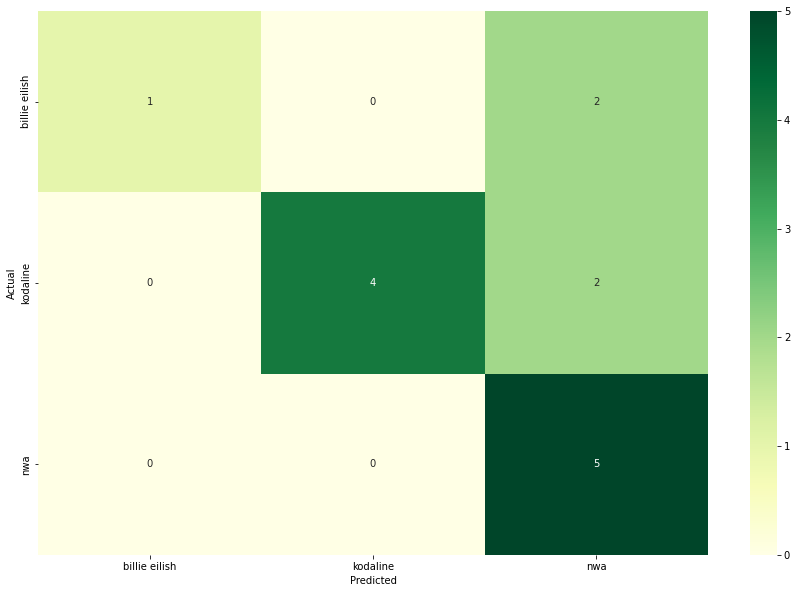

In [128]:
plt.figure(figsize=(15, 10))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='.2g', cmap='YlGn', 
            xticklabels=bayes_model.classes_, 
           yticklabels=bayes_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')

## Log Model

In [66]:
log_model = LogisticRegression()

In [67]:
log_model.fit(vec_song_new, y_train)

LogisticRegression()

In [68]:
log_model.score(vec_song_new, y_train)

1.0

In [69]:
y_pred_log = log_model.predict(vec_test_new)

In [70]:
log_model.score(vec_test_new, y_test)

0.9285714285714286

In [71]:
cm, precision, recall = print_evaluations(y_test, y_pred_log, 'log_model')

How does model log_model score:
The accuracy of the model is: 0.9285714285714286
The precision of the model is: 0.9285714285714286
The recall of the model is: 0.9285714285714286
The f1-score of the model is: 0.9285714285714286


Text(51.0, 0.5, 'Actual')

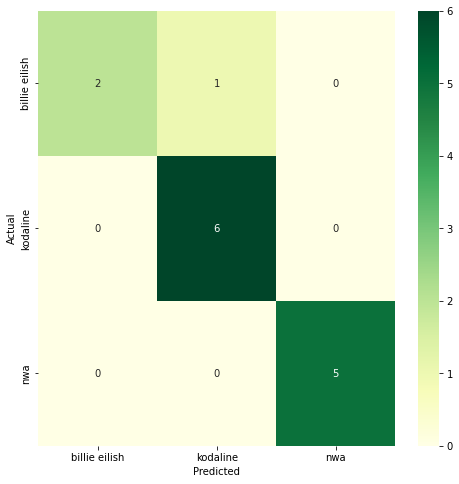

In [135]:
plt.figure(figsize=(8, 8))
sns.heatmap(confusion_matrix(y_test, y_pred_log), annot=True, fmt='.2g', cmap='YlGn',
           xticklabels=log_model.classes_, 
           yticklabels=log_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')

## GradientBoosting Classifier

In [120]:
boost_model = GradientBoostingClassifier(learning_rate=0.1, n_estimators=500, max_depth=5)

In [121]:
boost_model.fit(vec_song_new, y_train)

GradientBoostingClassifier(max_depth=5, n_estimators=500)

In [122]:
boost_model.score(vec_song_new, y_train)

1.0

In [123]:
y_pred_boost = boost_model.predict(vec_test_new)

In [124]:
boost_model.score(vec_test_new, y_test)

0.9285714285714286

In [125]:
cm, precision, recall = print_evaluations(y_test, y_pred_boost, 'boost_model')

How does model boost_model score:
The accuracy of the model is: 0.9285714285714286
The precision of the model is: 0.9285714285714286
The recall of the model is: 0.9285714285714286
The f1-score of the model is: 0.9285714285714286


Text(114.0, 0.5, 'Actual')

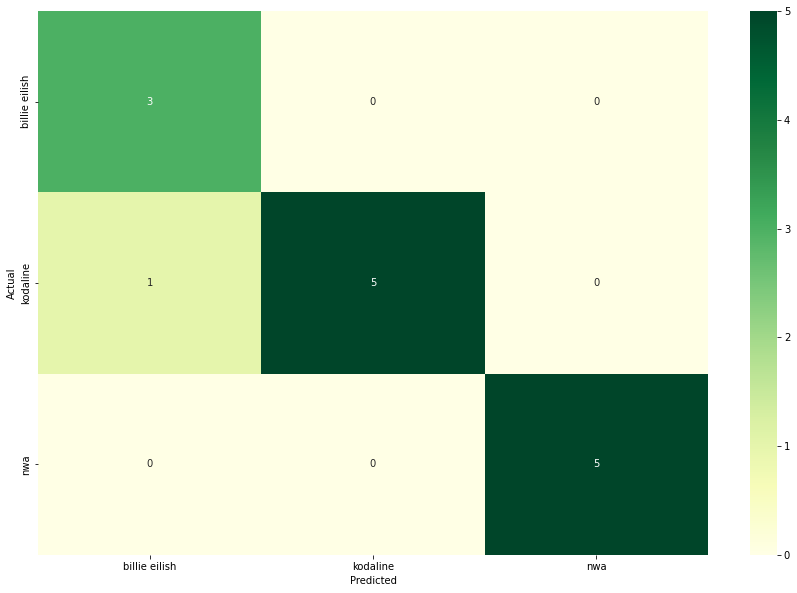

In [127]:
plt.figure(figsize=(15, 10))
sns.heatmap(confusion_matrix(y_test, y_pred_boost), annot=True, fmt='.2g', cmap='YlGn', 
            xticklabels=boost_model.classes_, 
           yticklabels=boost_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')